<a href="https://colab.research.google.com/github/Rishab12023/Modified-EfficientDet-D0-Model-with-CSPDarknet53-as-Backbone/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/matrix_ai_assignment')

In [59]:
%%capture
!pip install omegaconf
!pip install timm
!pip install ensemble_boxes
!pip install pytorch_lightning

In [4]:
import json
from pathlib import Path
import pandas as pd

In [5]:
# def json2pickle(input_filepath, output_filepath):
#     with open(Path(input_filepath), 'r') as f:
#         a = json.load(f)

#     b = a['annotations']
#     df_data = pd.DataFrame(b)
#     req_df = df_data[['image_id', 'bbox', 'category_id']]
#     req_df.to_pickle(Path(output_filepath))

In [6]:
# json2pickle(input_filepath = r"C:\Users\my hp\Downloads\food-dataset-10-tat-10\food-dataset-10-tat-10\annotations\instances_test2017.json",
#            output_filepath = r"C:\Users\my hp\Downloads\food-dataset-10-tat-10\food-dataset-10-tat-10\annotations\instances_test2017.pkl")

In [80]:
import matplotlib.pyplot as plt
from matplotlib import patches

def get_rectangle_edges_from_pascal_bbox(bbox):
    xmin_top_left, ymin_top_left, xmax_bottom_right, ymax_bottom_right = bbox

    bottom_left = (xmin_top_left, ymax_bottom_right)
    width = xmax_bottom_right - xmin_top_left
    height = ymin_top_left - ymax_bottom_right

    return bottom_left, width, height

def draw_pascal_voc_bboxes(
    plot_ax,
    bboxes,
    get_rectangle_corners_fn=get_rectangle_edges_from_pascal_bbox,
):
    for bbox in bboxes:
        bottom_left, width, height = get_rectangle_corners_fn(bbox)

        rect_1 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=4,
            edgecolor="black",
            fill=False,
        )
        rect_2 = patches.Rectangle(
            bottom_left,
            width,
            height,
            linewidth=2,
            edgecolor="white",
            fill=False,
        )

        # Add the patch to the Axes
        plot_ax.add_patch(rect_1)
        plot_ax.add_patch(rect_2)

def show_image(
    image, bboxes=None, draw_bboxes_fn=draw_pascal_voc_bboxes, figsize=(10, 10)
):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    if bboxes is not None:
        draw_bboxes_fn(ax, bboxes)

    plt.show()

In [28]:
from pathlib import Path

import PIL

import numpy as np

class appliancesDatasetAdaptor:
    def __init__(self, images_dir_path, annotations_dataframe):
        self.images_dir_path = Path(images_dir_path)
        self.annotations_df = annotations_dataframe
        self.images = self.annotations_df['image_id'].unique().tolist()

    def __len__(self) -> int:
        return len(self.images)

    def get_image_and_labels_by_idx(self, index):
        image_name = f"{(self.images[index])}.jpg"
        image = PIL.Image.open(self.images_dir_path / image_name)
        pascal_bboxes = self.annotations_df[self.annotations_df['image_id'] == self.images[index]]["bbox"].values
        class_labels = self.annotations_df[self.annotations_df['image_id'] == self.images[index]]['category_id'].values
        # print(type(image))
        return image, pascal_bboxes, class_labels, self.images[index]

    def show_image(self, index):
        image, bboxes, class_labels, image_id = self.get_image_and_labels_by_idx(index)
        print(f"image_id: {image_id}")
        print(f"class_labels: {class_labels}")
        print(bboxes.tolist())
        show_image(image, bboxes.tolist())
        print(class_labels)

In [29]:
train_df = pd.read_pickle(r"/content/drive/MyDrive/matrix_ai_assignment/data/appliance-dataset-5-tat-10/annotations/instances_train2017.pkl")
train_data_path = r"/content/drive/MyDrive/matrix_ai_assignment/data/appliance-dataset-5-tat-10/images/train2017"
val_df = pd.read_pickle(r"/content/drive/MyDrive/matrix_ai_assignment/data/appliance-dataset-5-tat-10/annotations/instances_val2017.pkl")
val_data_path = r"/content/drive/MyDrive/matrix_ai_assignment/data/appliance-dataset-5-tat-10/images/val2017"

In [30]:
train_df[(train_df['image_id'] == 100003)]

,image_id,bbox,category_id
3,100003,"[399.97, 69.02, 84.48, 159.53]",1
277,100003,"[355.01, 92.65, 46.54, 27.79]",3
1049,100003,"[326.35, 156.99, 102.7, 20.43]",4


In [31]:
appliances_train_ds = appliancesDatasetAdaptor(train_data_path, train_df)
appliances_val_ds = appliancesDatasetAdaptor(val_data_path, val_df)

image_id: 100003
class_labels: [1 3 4]
[[399.97, 69.02, 84.48, 159.53], [355.01, 92.65, 46.54, 27.79], [326.35, 156.99, 102.7, 20.43]]


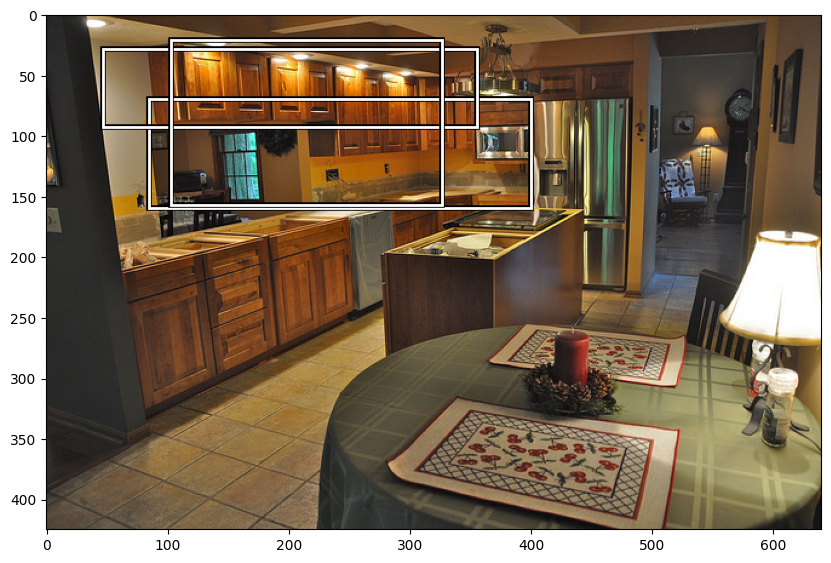

[1 3 4]


In [32]:
appliances_train_ds.show_image(3)

In [33]:
from config.model_config import efficientdet_model_param_dict, get_efficientdet_config
from efficientdet import EfficientDet, HeadNet
from bench import DetBenchTrain

In [34]:
print(f'number of configs: {len(efficientdet_model_param_dict)}')
list(efficientdet_model_param_dict.keys())[::3]

number of configs: 47


['efficientdet_d0',
 'efficientdet_d3',
 'efficientdetv2_dt',
 'cspresdet50',
 'cspdarkdet53',
 'mixdet_l',
 'mobiledetv3_large',
 'efficientdet_q2',
 'efficientdet_em',
 'tf_efficientdet_d1',
 'tf_efficientdet_d4',
 'tf_efficientdet_d7',
 'tf_efficientdet_d1_ap',
 'tf_efficientdet_d4_ap',
 'tf_efficientdet_lite1',
 'tf_efficientdet_lite3x']

In [35]:
import timm
timm.list_models("cspdarknet53")

['cspdarknet53']

In [36]:
def create_model(num_classes=1, image_size=512, architecture="cspdarkdet53"):
    efficientdet_model_param_dict['cspdarkdet53'] = dict(
        name='cspdarkdet53',
        backbone_name='cspdarkdet53',
        backbone_args=dict(drop_path_rate=0.2),
        num_classes=num_classes,
        url='', )

    config = get_efficientdet_config(architecture)
    config.update({'num_classes': num_classes})
    config.update({'image_size': (image_size, image_size)})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    net.class_net = HeadNet(
        config,
        num_outputs=config.num_classes,
    )
    return DetBenchTrain(net, config)

In [37]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

def get_train_transforms(target_img_size=512):
    return transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.Resize((target_img_size, target_img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

def get_valid_transforms(target_img_size=512):
    return transforms.Compose([
        transforms.Resize((target_img_size, target_img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class EfficientDetDataset(Dataset):
    def __init__(self, dataset_adaptor, transforms=get_valid_transforms()):
        self.ds = dataset_adaptor
        self.transforms = transforms

    def __getitem__(self, index):
        image, pascal_bboxes, class_labels, image_id = self.ds.get_image_and_labels_by_idx(index)
        # image = transforms.ToPILImage()(image)  # Convert numpy array to PIL Image for transformation
        image = self.transforms(image)  # Apply transformations

        if isinstance(pascal_bboxes, np.ndarray):
            if pascal_bboxes.dtype == np.object_:  # Check if the dtype is object
                # Try converting it to a proper numeric type (float)
                pascal_bboxes = np.stack(pascal_bboxes).astype(np.float32)
        else:
            # Convert a list of bboxes to a NumPy array if not already an array
            pascal_bboxes = np.array(pascal_bboxes, dtype=np.float32)

        # You would need to handle bounding boxes separately if you want them transformed as torchvision doesn't directly support bbox transformations
        bboxes = torch.tensor(pascal_bboxes, dtype=torch.float32)
        labels = torch.tensor(class_labels, dtype=torch.int64)

        # Transform bounding boxes manually if necessary (e.g., rescaling)
        # This is a simplistic approach; you might need to adjust the bbox coordinates based on the resize operation.

        target = {
            "bboxes": bboxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "img_size": (image.size(1), image.size(2)),  # Height and width
            "img_scale": torch.tensor([1.0])
        }

        return image, target, image_id

    def __len__(self):
        return len(self.ds)

In [68]:
import torch
from torch.utils.data import DataLoader

class EfficientDetDataModule:

    def __init__(self,
                 train_dataset_adaptor,
                 validation_dataset_adaptor,
                 train_transforms=get_train_transforms(target_img_size=512),
                 valid_transforms=get_valid_transforms(target_img_size=512),
                 num_workers=4,
                 batch_size=2):

        self.train_ds = train_dataset_adaptor
        self.valid_ds = validation_dataset_adaptor
        self.train_tfms = train_transforms
        self.valid_tfms = valid_transforms
        self.num_workers = num_workers
        self.batch_size = batch_size

    def train_dataset(self):
        return EfficientDetDataset(
            dataset_adaptor=self.train_ds, transforms=self.train_tfms
        )

    def train_dataloader(self):
        train_dataset = self.train_dataset()
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )
        return train_loader

    def val_dataset(self):
        return EfficientDetDataset(
            dataset_adaptor=self.valid_ds, transforms=self.valid_tfms
        )

    def val_dataloader(self):
        valid_dataset = self.val_dataset()
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            pin_memory=True,
            drop_last=True,
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
        )
        return valid_loader

    @staticmethod
    def collate_fn(batch):
        images, targets, image_ids = tuple(zip(*batch))
        images = torch.stack(images).float()

        boxes = [target['bboxes'].float() for target in targets]
        labels = [target['labels'].float() for target in targets]
        img_size = torch.tensor([target['img_size'] for target in targets]).float()
        img_scale = torch.tensor([target['img_scale'] for target in targets]).float()

        annotations = {
            'bbox': boxes,
            'cls': labels,
            'img_size': img_size,
            'img_scale': img_scale,
        }

        return images, annotations, image_ids


In [69]:
# Usage
train_dataset_adaptor = appliances_train_ds# Replace with actual dataset adaptor
validation_dataset_adaptor = appliances_val_ds # Replace with actual dataset adaptor
module = EfficientDetDataModule(train_dataset_adaptor, validation_dataset_adaptor)
train_loader = module.train_dataloader()
valid_loader = module.val_dataloader()

In [74]:
import torch
from torchvision.transforms import functional as F

def custom_collate_fn(batch):
    images, targets, image_ids = tuple(zip(*batch))
    images = torch.stack(images).float()

    boxes = [target['bboxes'].float() for target in targets]
    labels = [target['labels'].float() for target in targets]
    img_size = torch.tensor([target['img_size'] for target in targets]).float()
    img_scale = torch.tensor([target['img_scale'] for target in targets]).float()

    # idxs = np.random.permutation(len(imgs))

    # Specify the output size and scale range for the mosaic
    output_size = (512, 512)  # Example fixed size
    scale_range = (0.5, 1.0)  # Scale range for dividing the images
    annos = []
    for i in range(len(labels)):
      arr = []
      arr.append(labels[i])
      for j in range(4):
        arr.append(boxes[i][j])
      annos.append(arr)

    image_ids = list(range(len(labels)))
    # Create mosaic image and annotations
    mosaic_img, mosaic_annos = mosaic(images, annos, image_ids, output_size, scale_range)

    # Convert mosaic image back to tensor
    mosaic_img_tensor = F.to_tensor(mosaic_img)

    # Package the new batch
    new_batch = {
        'imgs': mosaic_img_tensor,
        'annos': mosaic_annos,
        # Handle other necessary metadata here
    }

    return new_batch

In [79]:
import random

import cv2
import os
import glob
import numpy as np
from PIL import Image

def mosaic(all_img_list, all_annos, idxs, output_size, scale_range, filter_scale=0.):
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    scale_x = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    scale_y = scale_range[0] + random.random() * (scale_range[1] - scale_range[0])
    divid_point_x = int(scale_x * output_size[1])
    divid_point_y = int(scale_y * output_size[0])

    new_anno = []
    for i, idx in enumerate(idxs):
        path = all_img_list[idx]
        img_annos = all_annos[idx]

        img = path
        if i == 0:  # top-left
            img = cv2.resize(img, (divid_point_x, divid_point_y))
            output_img[:divid_point_y, :divid_point_x, :] = img
            for bbox in img_annos:

                # As YOLO annotations have different centers from the image, this is how the bbox coordinates are calculated
                xmin = bbox[1] - bbox[3]*0.5
                ymin = bbox[2] - bbox[4]*0.5
                xmax = bbox[1] + bbox[3]*0.5
                ymax = bbox[2] + bbox[4]*0.5

                xmin *= scale_x
                ymin *= scale_y
                xmax *= scale_x
                ymax *= scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

        elif i == 1:  # top-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, divid_point_y))
            output_img[:divid_point_y, divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = bbox[1] - bbox[3]*0.5
                ymin = bbox[2] - bbox[4]*0.5
                xmax = bbox[1] + bbox[3]*0.5
                ymax = bbox[2] + bbox[4]*0.5

                xmin = scale_x + xmin * (1 - scale_x)
                ymin = ymin * scale_y
                xmax = scale_x + xmax * (1 - scale_x)
                ymax = ymax * scale_y
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        elif i == 2:  # bottom-left
            img = cv2.resize(img, (divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], :divid_point_x, :] = img
            for bbox in img_annos:
                xmin = bbox[1] - bbox[3]*0.5
                ymin = bbox[2] - bbox[4]*0.5
                xmax = bbox[1] + bbox[3]*0.5
                ymax = bbox[2] + bbox[4]*0.5

                xmin = xmin * scale_x
                ymin = scale_y + ymin * (1 - scale_y)
                xmax = xmax * scale_x
                ymax = scale_y + ymax * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])
        else:  # bottom-right
            img = cv2.resize(img, (output_size[1] - divid_point_x, output_size[0] - divid_point_y))
            output_img[divid_point_y:output_size[0], divid_point_x:output_size[1], :] = img
            for bbox in img_annos:
                xmin = bbox[1] - bbox[3]*0.5
                ymin = bbox[2] - bbox[4]*0.5
                xmax = bbox[1] + bbox[3]*0.5
                ymax = bbox[2] + bbox[4]*0.5

                xmin = scale_x + xmin * (1 - scale_x)
                ymin = scale_y + ymin * (1 - scale_y)
                xmax = scale_x + xmax * (1 - scale_x)
                ymax = scale_y + ymax * (1 - scale_y)
                new_anno.append([bbox[0], xmin, ymin, xmax, ymax])

    if 0 < filter_scale:
        new_anno = [anno for anno in new_anno if
                    filter_scale < (anno[3] - anno[1]) and filter_scale < (anno[4] - anno[2])]

    return output_img, new_anno

In [73]:
for images, labels, _ in train_loader:
    print(images)
    print(labels)
    print(images.shape)
    # print(f"Before CutMix/MixUp: {images.shape = }, {labels.shape = }")
    images, labels = cutmix_or_mixup(images, labels)
    print(f"After CutMix/MixUp: {images.shape = }, {labels.shape = }")
    # <rest of the training loop here>
    break

tensor([[[[-0.0972, -0.0287, -0.0287,  ..., -1.2103, -1.1932, -1.2445],
          [-0.0972, -0.0287,  0.0227,  ..., -1.1247, -1.1760, -1.1760],
          [-0.0458,  0.0227,  0.0398,  ..., -1.1932, -1.1760, -1.1418],
          ...,
          [-0.9705, -0.9534, -0.8678,  ..., -1.5014, -1.5357, -1.5528],
          [-0.8678, -0.9020, -0.8849,  ..., -1.4843, -1.4843, -1.5014],
          [-0.8849, -0.9877, -1.0048,  ..., -1.4158, -1.4158, -1.4672]],

         [[-0.4426, -0.3725, -0.3725,  ..., -1.0903, -1.0728, -1.1429],
          [-0.4076, -0.3550, -0.3375,  ..., -1.0028, -1.0553, -1.0728],
          [-0.3725, -0.3375, -0.3200,  ..., -1.0903, -1.0728, -1.0378],
          ...,
          [-1.5805, -1.5805, -1.5630,  ..., -1.7556, -1.7731, -1.7381],
          [-1.5280, -1.5805, -1.5280,  ..., -1.7556, -1.7381, -1.7206],
          [-1.5805, -1.6506, -1.5805,  ..., -1.6856, -1.6681, -1.6856]],

         [[-0.3927, -0.3753, -0.4275,  ..., -0.7936, -0.7587, -0.7761],
          [-0.5147, -0.4624, -

ValueError: Could not infer where the labels are in the sample. Try passing a callable as the labels_getter parameter?If there are no labels in the sample by design, pass labels_getter=None.

In [54]:
img, annotations, img_id  = next(iter(train_loader))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [60]:
annotations

{'bbox': [tensor([[159.4800, 110.4300,  66.2200,  34.5400],
          [459.5100, 117.2400, 138.0600, 190.9200],
          [280.7400, 145.7800,  49.5400,  15.0100]]),
  tensor([[  0.0000, 164.9000, 154.3600, 172.4600],
          [283.9900, 352.9100, 107.2000,  42.1300],
          [432.7100, 338.2100,  89.6300,  39.0300],
          [557.2100, 284.3600,  47.5100,  34.2900],
          [481.8900, 269.8100,  74.9500,  33.0500]]),
  tensor([[ 69.5700, 112.2600, 138.0800, 302.5100],
          [381.7600, 270.2800, 110.4300, 161.9600],
          [536.6800, 294.2400, 103.3200,  25.2000]]),
  tensor([[357.5300, 143.9400, 122.4000, 399.4700],
          [289.2400, 537.1300, 126.1800, 102.8700],
          [  0.0000, 316.0500, 129.6700,  58.7800]]),
  tensor([[204.5000, 311.2400, 119.9700, 180.3300],
          [205.2000, 308.2200, 124.0700, 181.4100]]),
  tensor([[476.0400, 174.1200, 142.3900, 270.3800]]),
  tensor([[ 64.4300, 268.5600, 128.8600, 170.7400],
          [518.0500, 198.3100, 119.1800, 137

In [58]:
from numbers import Number
from typing import List
from functools import singledispatch

from ensemble_boxes import ensemble_boxes_wbf

import numpy as np
import torch

# from fastcore.dispatch import typedispatch
from pytorch_lightning import LightningModule
# from pytorch_lightning.core.decorators import auto_move_data


def run_wbf(predictions, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    bboxes = []
    confidences = []
    class_labels = []

    for prediction in predictions:
        boxes = [(prediction["boxes"] / image_size).tolist()]
        scores = [prediction["scores"].tolist()]
        labels = [prediction["classes"].tolist()]

        boxes, scores, labels = ensemble_boxes_wbf.weighted_boxes_fusion(
            boxes,
            scores,
            labels,
            weights=weights,
            iou_thr=iou_thr,
            skip_box_thr=skip_box_thr,
        )
        boxes = boxes * (image_size - 1)
        bboxes.append(boxes.tolist())
        confidences.append(scores.tolist())
        class_labels.append(labels.tolist())

    return bboxes, confidences, class_labels


class EfficientDetModel(LightningModule):
    def __init__(
        self,
        num_classes=1,
        img_size=512,
        prediction_confidence_threshold=0.2,
        learning_rate=0.0002,
        wbf_iou_threshold=0.44,
        inference_transforms=get_valid_transforms(target_img_size=512),
        model_architecture='cspdarknet53',
    ):
        super().__init__()
        self.img_size = img_size
        self.model = create_model(
            num_classes, img_size, architecture=model_architecture
        )
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.prediction_confidence_threshold = prediction_confidence_threshold
        self.lr = learning_rate
        self.wbf_iou_threshold = wbf_iou_threshold
        self.inference_tfms = inference_transforms


    def forward(self, images, targets):
        return self.model(images, targets)

    # def configure_optimizers(self):
    #     return

    def train_model(self, train_loader, num_epochs, logger=None):
        self.model.train()
        for epoch in range(num_epochs):
            for batch_idx, (images, annotations, _, image_ids) in enumerate(train_loader):
                images = images.to(self.device)
                annotations = {k: v.to(self.device) for k, v in annotations.items()}

                # Zero the gradients
                self.optimizer.zero_grad()

                # Forward pass
                losses = self.model(images, annotations)
                loss = losses['loss']

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Logging
                if logger is not None:
                    logger.log({
                        "train_loss": loss.item(),
                        "train_class_loss": losses['class_loss'].item(),
                        "train_box_loss": losses['box_loss'].item(),
                        "step": epoch * len(train_loader) + batch_idx
                    })

                # Optionally print the losses
                if batch_idx % 10 == 0:  # print every 10 batches
                    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}, Class Loss: {losses["class_loss"].item()}, Box Loss: {losses["box_loss"].item()}')
        return loss.item()

    @torch.no_grad()
    def validate_model(self, validation_loader, logger=None):
        self.model.eval()  # Set the model to evaluation mode
        total_loss = 0
        total_class_loss = 0
        total_box_loss = 0
        num_batches = 0

        with torch.no_grad():  # No gradients needed for validation
            for batch_idx, (images, annotations, targets, image_ids) in enumerate(validation_loader):
                images = images.to(self.device)
                annotations = {k: v.to(self.device) for k, v in annotations.items()}

                # Forward pass
                outputs = self.model(images, annotations)
                loss = outputs['loss']
                class_loss = outputs['class_loss']
                box_loss = outputs['box_loss']

                # Aggregate losses for averaging
                total_loss += loss.item()
                total_class_loss += class_loss.item()
                total_box_loss += box_loss.item()
                num_batches += 1

                # Optionally, log the detailed results
                if logger is not None:
                    logger.log({
                        "valid_loss": loss.item(),
                        "valid_class_loss": class_loss.item(),
                        "valid_box_loss": box_loss.item(),
                        "step": batch_idx
                    })

                # Print validation loss
                if batch_idx % 10 == 0:  # print every 10 batches
                    print(f'Validation Step [{batch_idx}/{len(validation_loader)}], Loss: {loss.item()}, Class Loss: {class_loss.item()}, Box Loss: {box_loss.item()}')

        # Average the losses
        avg_loss = total_loss / num_batches
        avg_class_loss = total_class_loss / num_batches
        avg_box_loss = total_box_loss / num_batches

        print(f'Average Validation Loss: {avg_loss}, Average Class Loss: {avg_class_loss}, Average Box Loss: {avg_box_loss}')

        return avg_loss, avg_class_loss, avg_box_loss

    def predict(self, images):
        if isinstance(images, list):
            # Handle list of PIL images
            image_sizes = [(image.size[1], image.size[0]) for image in images]
            images_tensor = torch.stack(
                [
                    self.inference_tfms(
                        image=np.array(image, dtype=np.float32),
                        labels=np.ones(1),
                        bboxes=np.array([[0, 0, 1, 1]]),
                    )["image"]
                    for image in images
                ]
            )
        elif isinstance(images, torch.Tensor):
            # Handle image tensor
            if images.ndim == 3:
                images = images.unsqueeze(0)
            if images.shape[-1] != self.img_size or images.shape[-2] != self.img_size:
                raise ValueError(f"Input tensors must be of shape (N, 3, {self.img_size}, {self.img_size})")
            image_sizes = [(self.img_size, self.img_size)] * images.shape[0]
            images_tensor = images
        else:
            raise ValueError("Unsupported input type")

        return self._run_inference(images_tensor, image_sizes)

    def _run_inference(self, images_tensor, image_sizes):
        dummy_targets = self._create_dummy_inference_targets(
            num_images=images_tensor.shape[0]
        )

        detections = self.model(images_tensor.to(self.device), dummy_targets)[
            "detections"
        ]
        (
            predicted_bboxes,
            predicted_class_confidences,
            predicted_class_labels,
        ) = self.post_process_detections(detections)

        scaled_bboxes = self.__rescale_bboxes(
            predicted_bboxes=predicted_bboxes, image_sizes=image_sizes
        )

        return scaled_bboxes, predicted_class_labels, predicted_class_confidences

    def _create_dummy_inference_targets(self, num_images):
        dummy_targets = {
            "bbox": [
                torch.tensor([[0.0, 0.0, 0.0, 0.0]], device=self.device)
                for i in range(num_images)
            ],
            "cls": [torch.tensor([1.0], device=self.device) for i in range(num_images)],
            "img_size": torch.tensor(
                [(self.img_size, self.img_size)] * num_images, device=self.device
            ).float(),
            "img_scale": torch.ones(num_images, device=self.device).float(),
        }

        return dummy_targets

    def post_process_detections(self, detections):
        predictions = []
        for i in range(detections.shape[0]):
            predictions.append(
                self._postprocess_single_prediction_detections(detections[i])
            )

        predicted_bboxes, predicted_class_confidences, predicted_class_labels = run_wbf(
            predictions, image_size=self.img_size, iou_thr=self.wbf_iou_threshold
        )

        return predicted_bboxes, predicted_class_confidences, predicted_class_labels

    def _postprocess_single_prediction_detections(self, detections):
        boxes = detections.detach().cpu().numpy()[:, :4]
        scores = detections.detach().cpu().numpy()[:, 4]
        classes = detections.detach().cpu().numpy()[:, 5]
        indexes = np.where(scores > self.prediction_confidence_threshold)[0]
        boxes = boxes[indexes]

        return {"boxes": boxes, "scores": scores[indexes], "classes": classes[indexes]}

    def __rescale_bboxes(self, predicted_bboxes, image_sizes):
        scaled_bboxes = []
        for bboxes, img_dims in zip(predicted_bboxes, image_sizes):
            im_h, im_w = img_dims

            if len(bboxes) > 0:
                scaled_bboxes.append(
                    (
                        np.array(bboxes)
                        * [
                            im_w / self.img_size,
                            im_h / self.img_size,
                            im_w / self.img_size,
                            im_h / self.img_size,
                        ]
                    ).tolist()
                )
            else:
                scaled_bboxes.append(bboxes)

        return scaled_bboxes

ModuleNotFoundError: No module named 'pytorch_lightning'

In [ ]:
dm = EfficientDetDataModule(train_dataset_adaptor=cars_train_ds,
        validation_dataset_adaptor=cars_train_ds,
        num_workers=1,
        batch_size=2)

NameError: name 'EfficientDetDataModule' is not defined

In [ ]:
model = EfficientDetModel(
    num_classes=1,
    img_size=512
    )